# Only run this once!
We're adding one directory up to the path so that we can import modules from `metabayes`

In [1]:
import sys
sys.path.append('..')

# Importing other libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from metabayes import GibbsSampler, Prior

plt.style.use('ggplot')

# Creating synthetic data
Here we will create synthetic datasets with different sample sizes, true effects, and baseline conversion rates.

In [3]:
num_experiments = 50

# Specifying sample sizes per variant
sample_size_min = 10000
sample_size_max = 200000

# Describing the distribution of true effects
true_effect_mean = 0.01
true_effect_sd = 0.025

true_control_means = np.random.beta(100, 150, size=num_experiments)
true_effects = np.random.normal(true_effect_mean, true_effect_sd, size=num_experiments)
true_treatment_means = true_control_means * (1 + true_effects)

sample_sizes = np.random.randint(sample_size_min, sample_size_max, size=num_experiments)
control_successes = np.random.binomial(sample_sizes, true_control_means)
treatment_successes = np.random.binomial(sample_sizes, true_treatment_means)

# Creating the prior
Here, we define a priors for the _true_ meta effect as well as the effect standard deviation.

In [4]:
prior = Prior()

## The prior for the meta effect
First, we show the prior distribution for the meta-effect. This distribution reflects prior uncertainty about the value of the true average effect (across all tests). Note that the model is essentially a _random effects_ model, so we do not assume that all tests have the same true effect.

For this prior, a normal distribution with a mean of zero is used. The default standard deviation of this distribution is 2.5%, which means we believe there is a 95% prior probability that the true meta effect is between -5% and 5%.

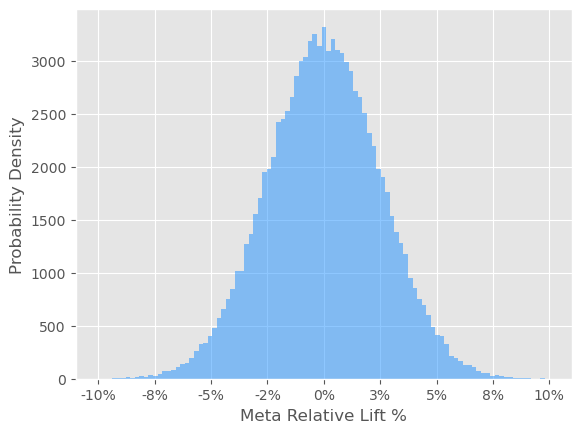

In [5]:
prior.plot_meta_effect_prior(color='dodgerblue', alpha=0.5)

## The prior for the effect standard deviation
This prior reflects uncertainty about the _heterogenity_ of the true effects measured in the tests. If every single test has the same true effect, the prior standard deviation would be zero. A large effect standard deviation corresponds to large differences in true effects across the tests.

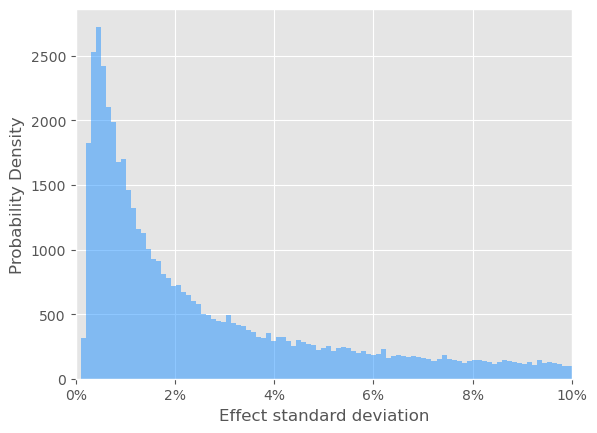

In [6]:
prior.plot_effect_sd_prior(color='dodgerblue', alpha=0.5)

# Running the model

In [7]:
gs = GibbsSampler.from_binary_counts(sample_sizes, control_successes, sample_sizes, treatment_successes, prior)
gs.run_model()
results = gs.get_posterior_samples()

100%|████████████████████████████████████| 9999/9999 [00:00<00:00, 24242.47it/s]


# Plotting
This is a good sanity check to make sure that the true effects generally fall within the high-density regions of the posterior distributions.

In [8]:
def plot(uplift, ax, i, true_value):
    ax.flatten()[i].hist(uplift, bins=50, density=True, alpha=.3, color='dodgerblue')
    ax.flatten()[i].set_title('Experiment {}'.format(i+1))
    ax.flatten()[i].axvline(x=true_value, color='black', label='True lift')
    ax.flatten()[i].axvline(x=np.mean(uplift), color='dodgerblue', linestyle='--', label='Posterior mean')
    ax.flatten()[i].set_xlabel('% lift')  
    ax.flatten()[i].set_ylabel('Density') 
    
    
    conf = np.quantile(uplift, [.25, .75])
    if i == 0:
        ax.flatten()[i].legend(bbox_to_anchor=(-.5, 1))

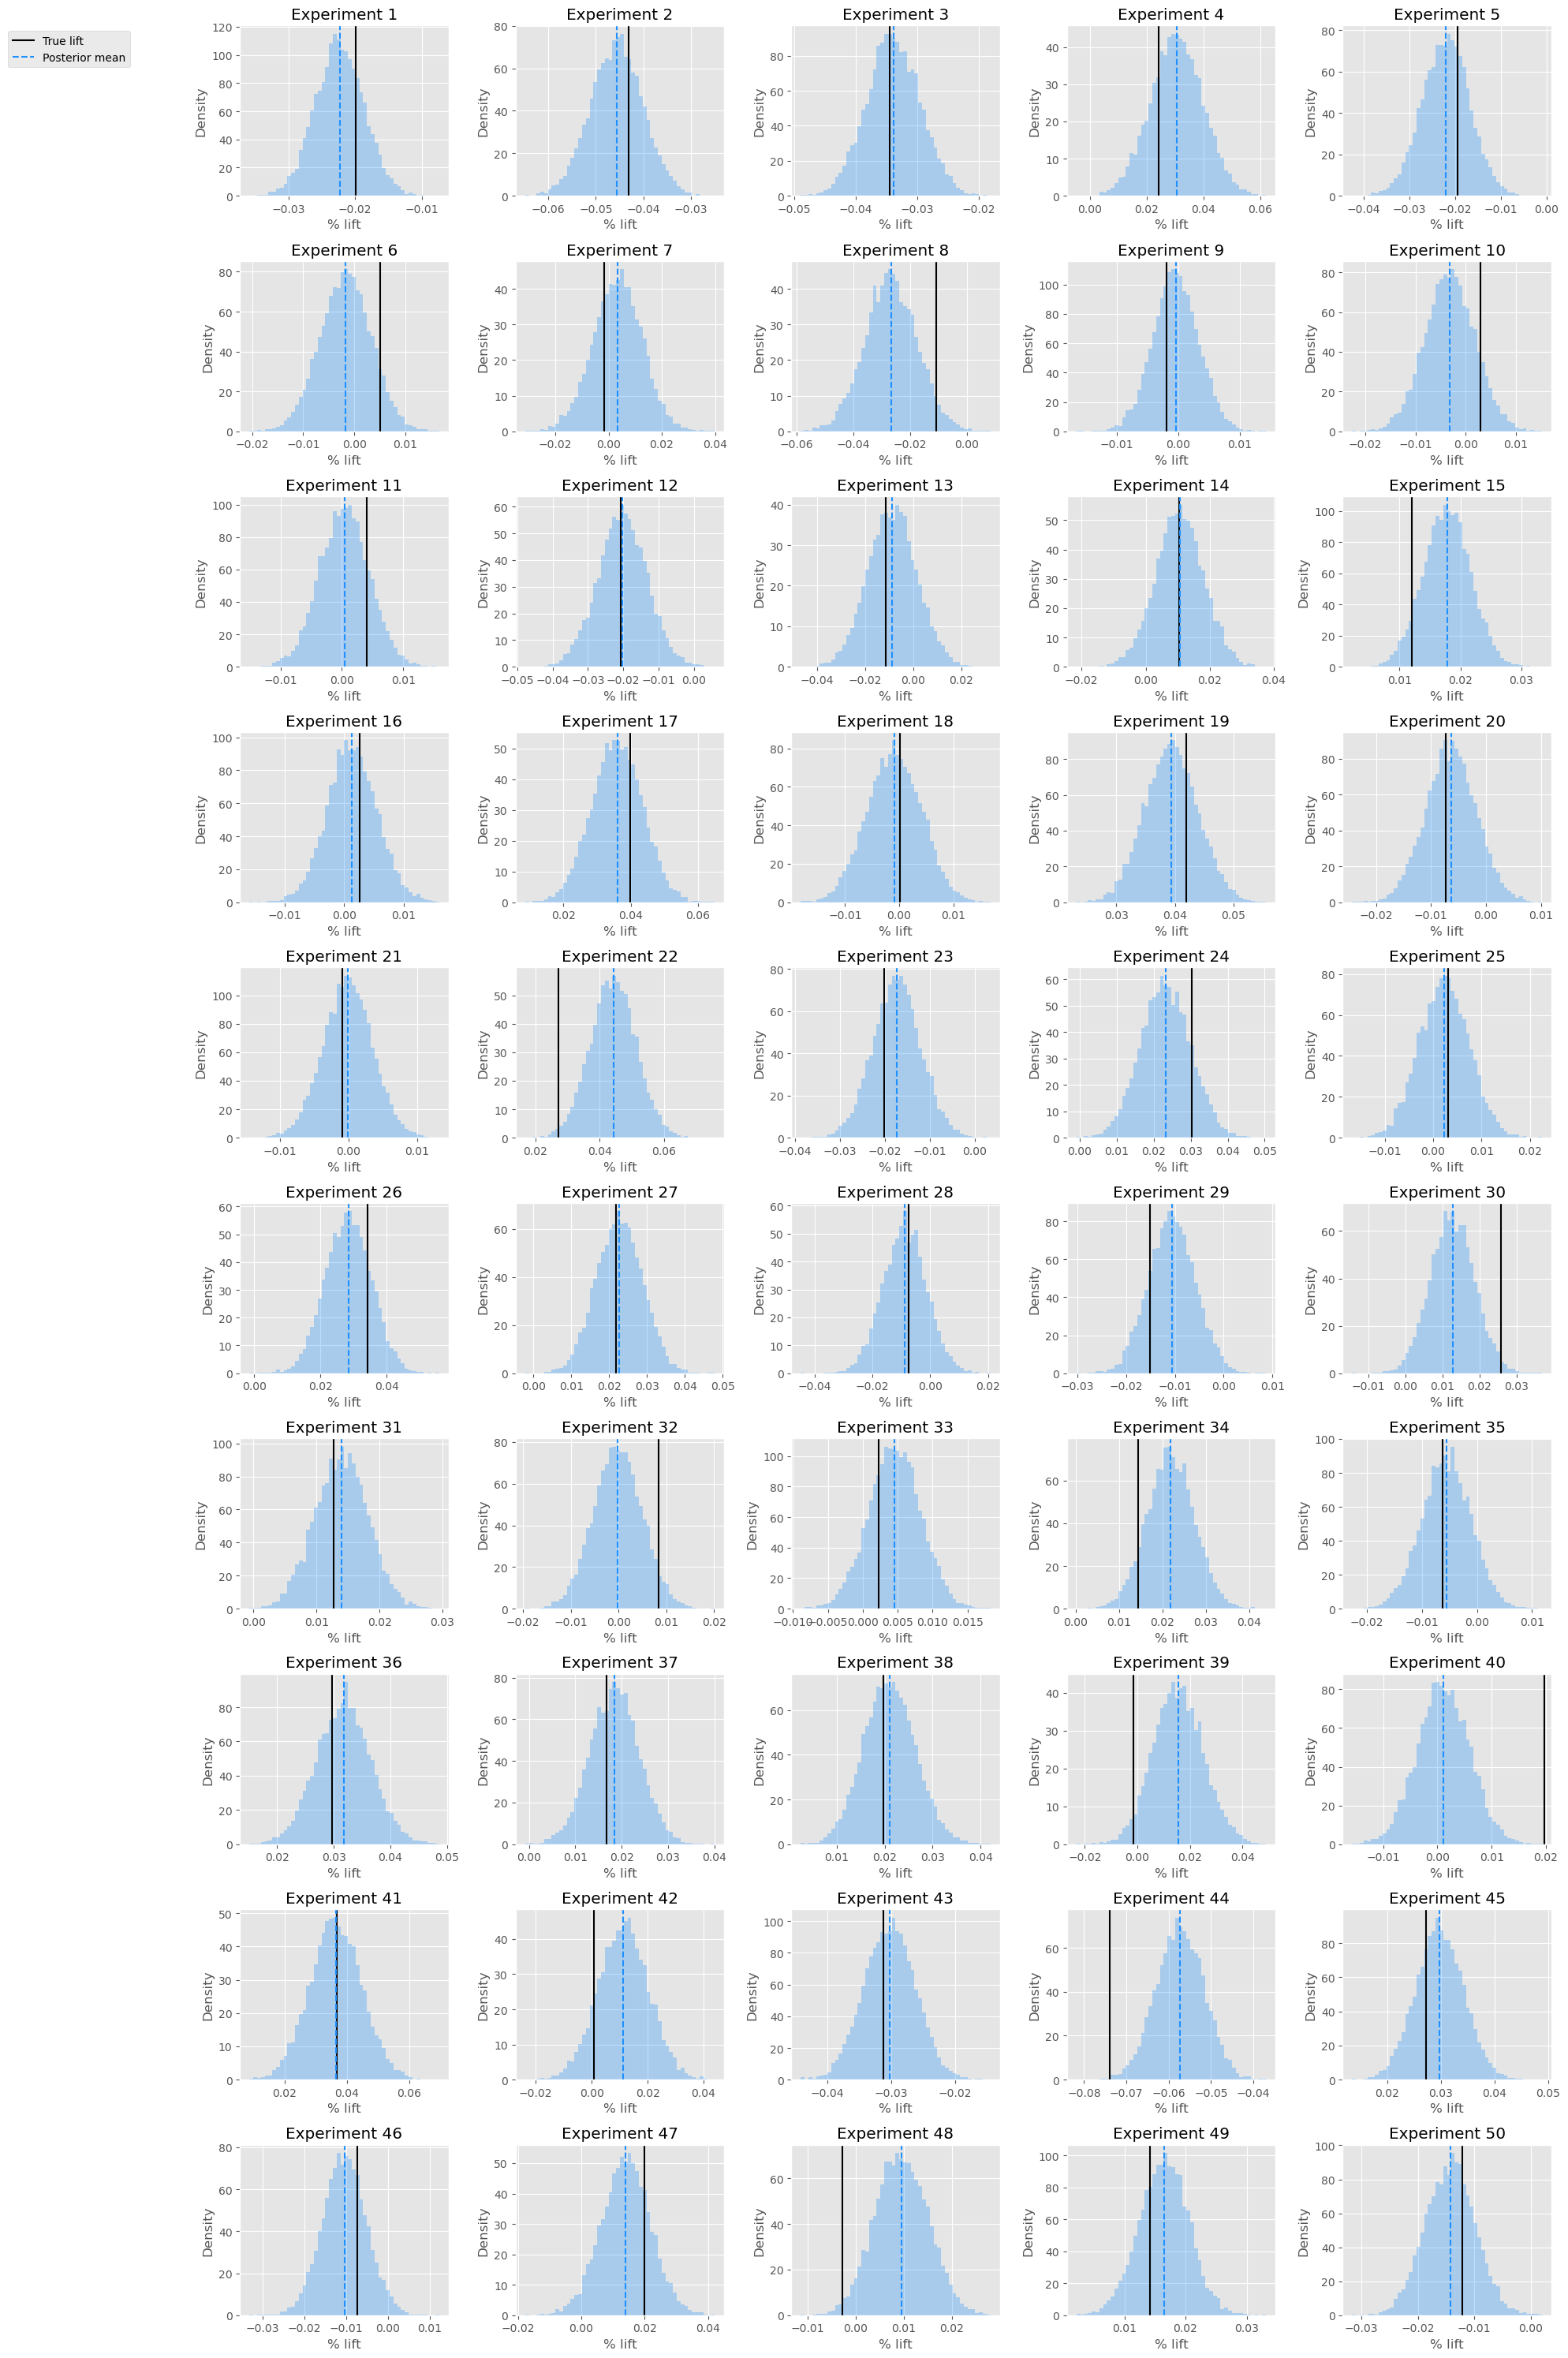

In [9]:
fig, ax = plt.subplots(ncols=5, nrows=10, figsize=(20, 30))
[plot(results['experiment_lifts'][:,i], ax, i, true_effects[i]) for i in range(num_experiments)]
fig.tight_layout()

## Checking to see how well the model infers the meta effect

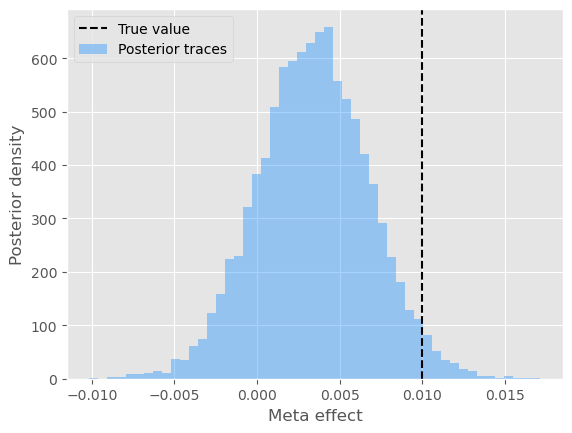

In [10]:
plt.hist(results['meta_lift'], bins=50, color='dodgerblue', alpha=0.4)
plt.axvline(true_effect_mean, color='k', linestyle='--')
plt.legend(['True value', 'Posterior traces'])
plt.xlabel('Meta effect')
plt.ylabel('Posterior density')
plt.show()

## Checking to see how well the model infers the true effect standard deviation

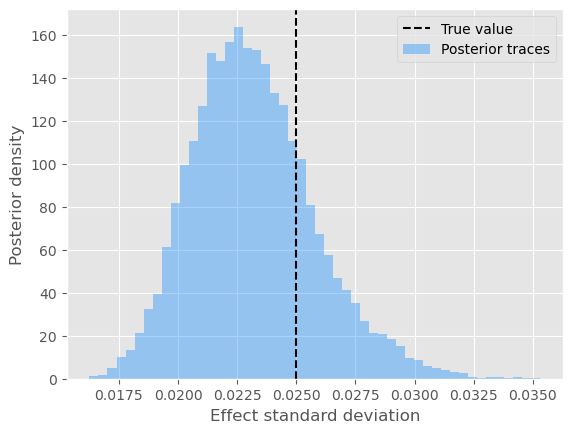

In [11]:
# Remember that tau is actually a precision, so we need to raise it to the power of -.5 to convert it to sd
plt.hist(results['lift_standard_deviation'], bins=50, color='dodgerblue', alpha=0.4, density=True)
plt.axvline(true_effect_sd, color='k', linestyle='--')
plt.legend(['True value', 'Posterior traces'])
plt.xlabel('Effect standard deviation')
plt.ylabel('Posterior density')
plt.show()